In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import glob,re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [208]:
param_pattern = re.compile(r'\d\d-\d\d-\d\d \d{6}_(?P<type>sin|tri|sqr|saw)_(?P<freq>\d+\.?\d*)_(?P<amp>\d+\.?\d*).*')
def getData(subpat):
    d = {}
    for f in glob.glob(subpat):
        result = param_pattern.findall(f)[0]
        (typ,freq,amp) = result
        freq,amp = float(freq),float(amp)
        if(typ not in d.keys()):
            d[typ]= {}
        if(freq not in d[typ].keys()):
            d[typ][freq] = {}
        if(amp not in d[typ][freq].keys()):
            d[typ][freq][amp] = []
        data = pd.read_csv(f)
        if(data.shape[0] > 0 and data.shape[1] > 0):
            d[typ][freq][amp].append(data)
    return d

In [202]:
def calcAveAndStd(data):
    n = len(data)
    
    ave = data[0].copy()
    for d in data[1:]:
        ave += d.copy()
    
    ave = ave / n
    
    std = (ave - data[0].copy())**2
    for d in data[1:]:
        std += (ave - d.copy())**2
    
    std = (std / n).apply(np.sqrt)
    std['Generation'] = ave.copy()['Generation']
    return ave,std

In [203]:
def calcAllStats(data):
    aves,stds = {},{}

    for typ in data.keys():
        aves[typ],stds[typ] = {},{}
        for freq in data[typ]:
            aves[typ][freq],stds[typ][freq] = {},{}
            for amp in data[typ][freq]:
                aves[typ][freq][amp],stds[typ][freq][amp] = calcAveAndStd(data[typ][freq][amp])
    return aves,stds

In [204]:
def gaTrace(data,error,sortedKeys = None,ci_multipler = 1.95,fig=None,ax=None):
    
    if(sortedKeys is None):
        sortedKeys = sorted(data.keys())
    
    n = len(sortedKeys)
    
    seaborn.set_style('white')
    seaborn.set_context("paper", font_scale=2, rc={"lines.linewidth": 1.5})
    # colors = seaborn.cubehelix_palette(7, start=1, rot=-5,dark=.1, light=.5)
    colors = seaborn.husl_palette(n,l=.4)
    shaded = np.hstack([colors,0.25*np.ones((n,1))])
    
    if(fig is None or ax is None):
        fig,ax = plt.subplots(figsize=(15,9))
    
    for i,k in enumerate(sortedKeys):
        u = data[k]['Max fitness']
        ci = error[k]['Max fitness']*ci_multipler

        ax.plot(u,color=colors[i],label=k)
        ax.fill_between(data[k]['Generation']-1,u-ci,u+ci,color=shaded[i])

    return fig,ax

In [205]:
def drawAllGAPlots_amps(aves,stds):
    for typ in aves.keys():
        for freq in aves[typ].keys():
            fig,ax = gaTrace(aves[typ][freq],stds[typ][freq])

            plt.title("%s    %s" % (typ, freq))
            plt.ylabel('Maximum fitness')
            plt.xlabel('Generation')
            plt.legend(loc='lower right')
            fig.show()

In [206]:
def getFreqSummary(aves,stds):
    new_aves,new_stds = {},{}
    for typ in aves.keys():
        new_aves[typ],new_stds[typ] = {},{}
        for freq in aves[typ]:
            keys = list(aves[typ][freq].keys())
            
            new_aves[typ][freq] = aves[typ][freq][keys[0]].copy()
            new_stds[typ][freq] = stds[typ][freq][keys[0]].copy()
            for k in keys[1:]:
                new_aves[typ][freq] += aves[typ][freq][k].copy()
                new_stds[typ][freq] += stds[typ][freq][k].copy()
                
            new_aves[typ][freq] /= len(keys)
            new_stds[typ][freq] /= len(keys)
            
    return new_aves,new_stds

def drawAllGAPlots_freqs(aves,stds):
    for typ in aves.keys():
        fig,ax = gaTrace(aves[typ],stds[typ])

        plt.title(typ)
        plt.ylabel('Maximum fitness')
        plt.xlabel('Generation')
        plt.legend(loc='lower right')
        fig.show()
        
def getTypSummary(aves,stds):
    new_aves,new_stds = {},{}
    for typ in aves.keys():
        keys = list(aves[typ].keys())

        new_aves[typ] = aves[typ][keys[0]].copy()
        new_stds[typ] = stds[typ][keys[0]].copy()
        for k in keys[1:]:
            new_aves[typ] += aves[typ][k].copy()
            new_stds[typ] += stds[typ][k].copy()

        new_aves[typ] /= len(keys)
        new_stds[typ] /= len(keys)
            
    return new_aves,new_stds

def drawGAPlots_typs(aves,stds):
    fig,ax = gaTrace(aves,stds)

    plt.title("GA summary by input type")
    plt.ylabel('Maximum fitness')
    plt.xlabel('Generation')
    plt.legend(loc='lower right')
    return fig

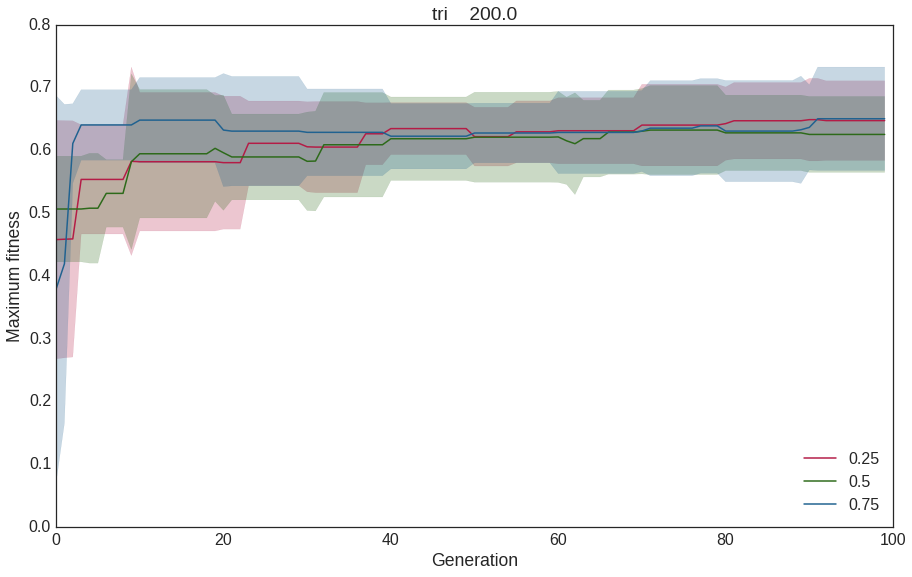

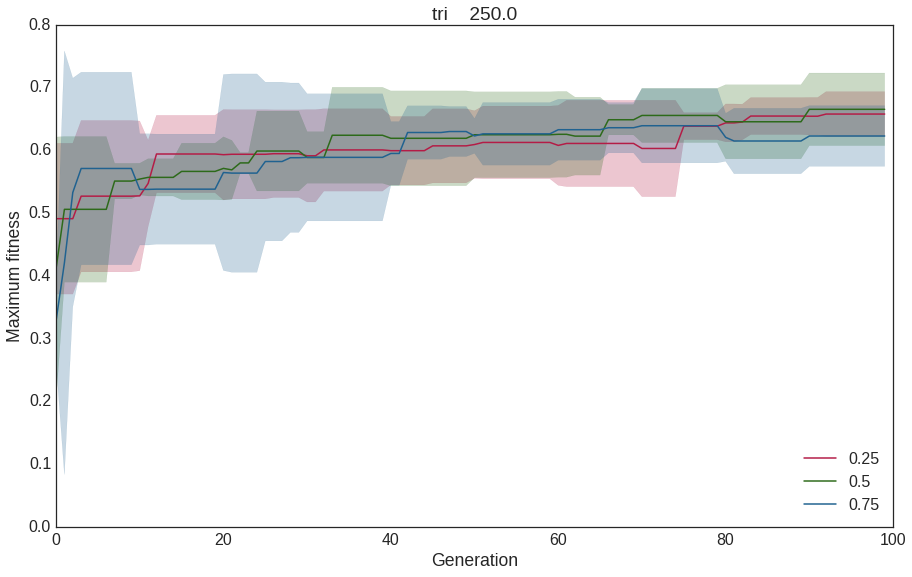

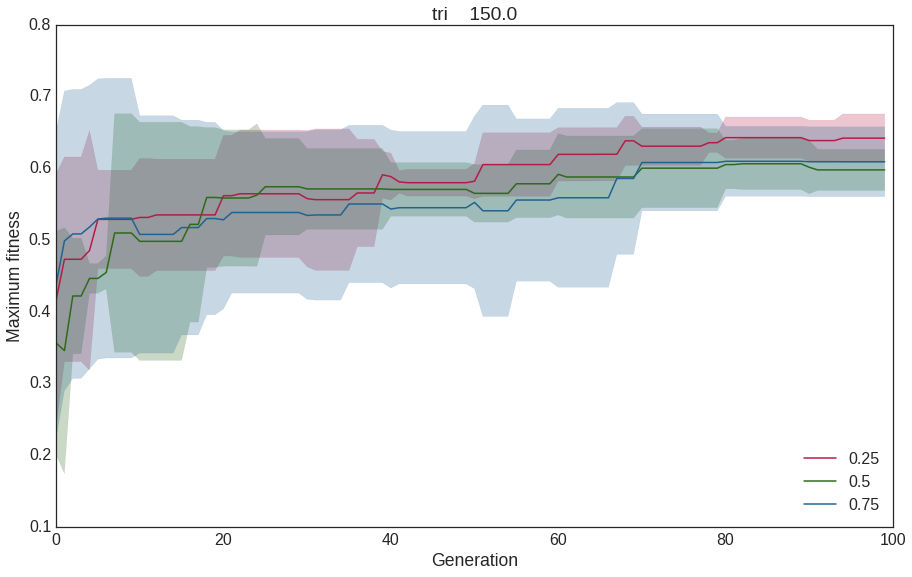

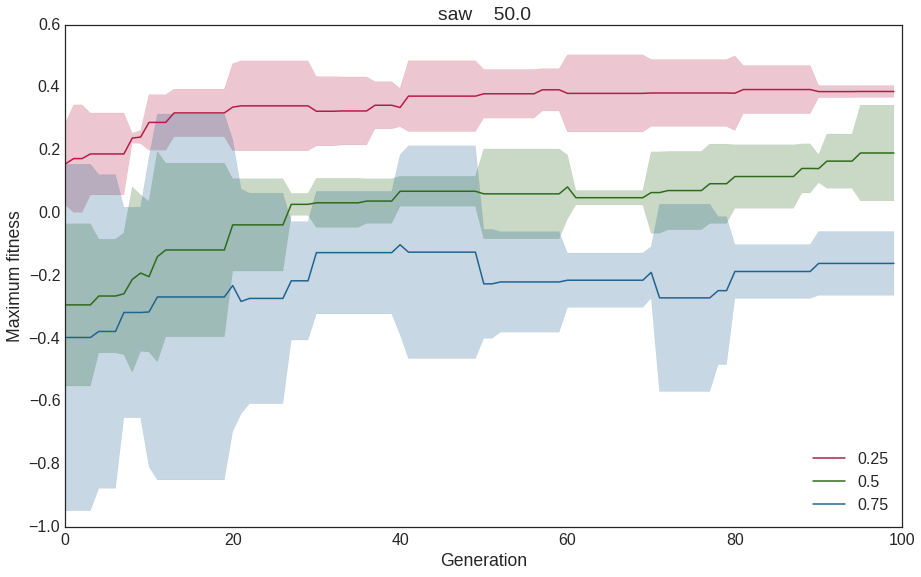

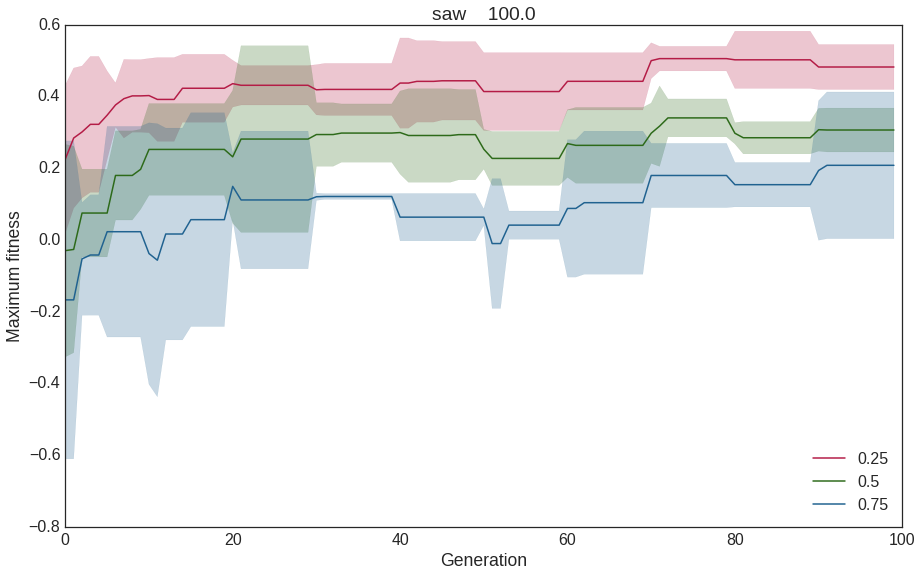

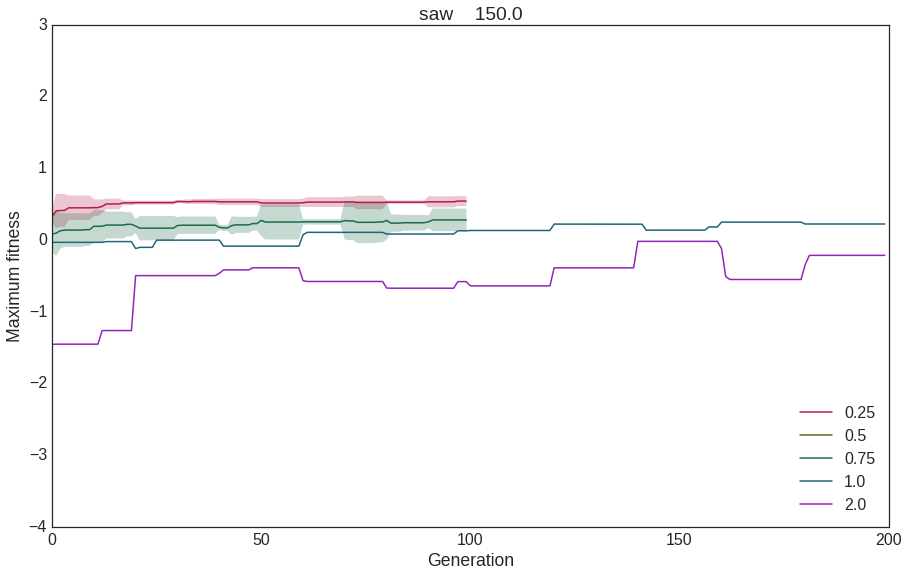

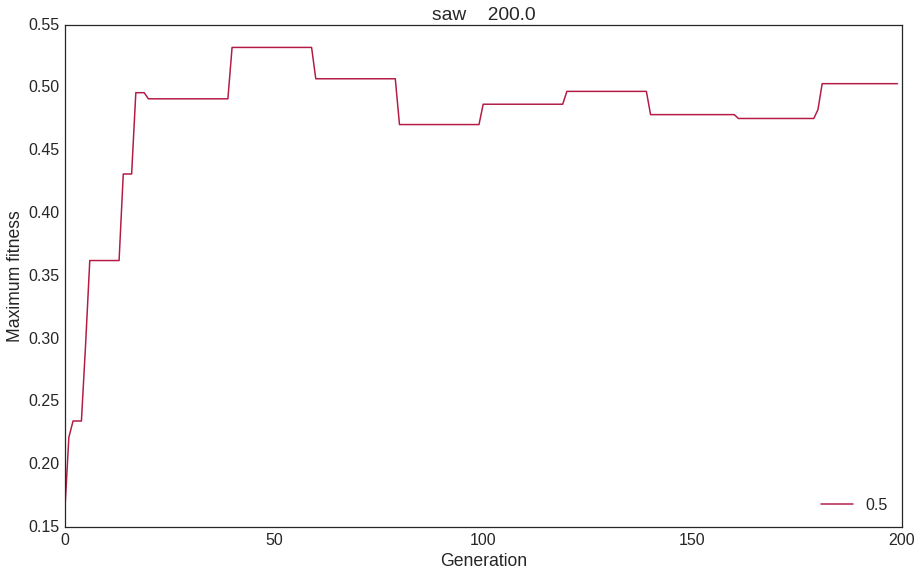

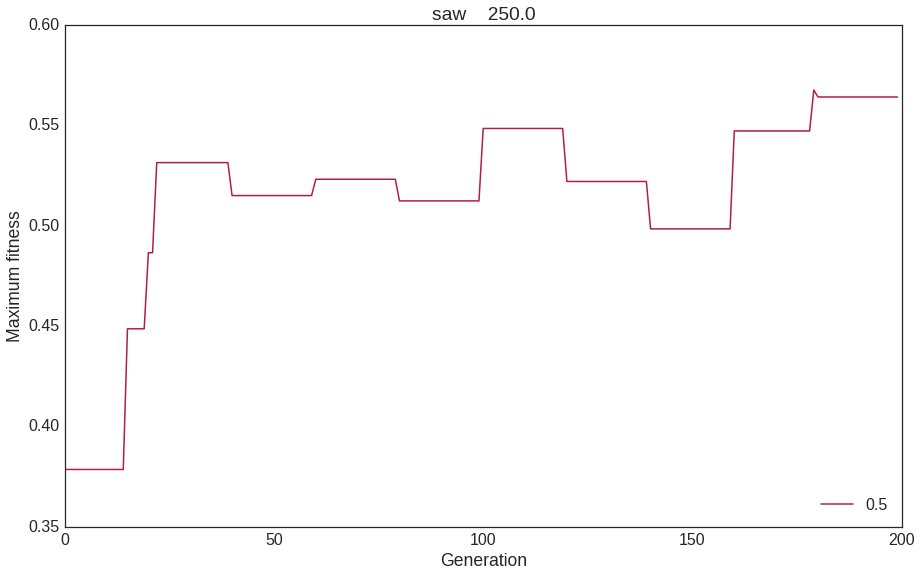

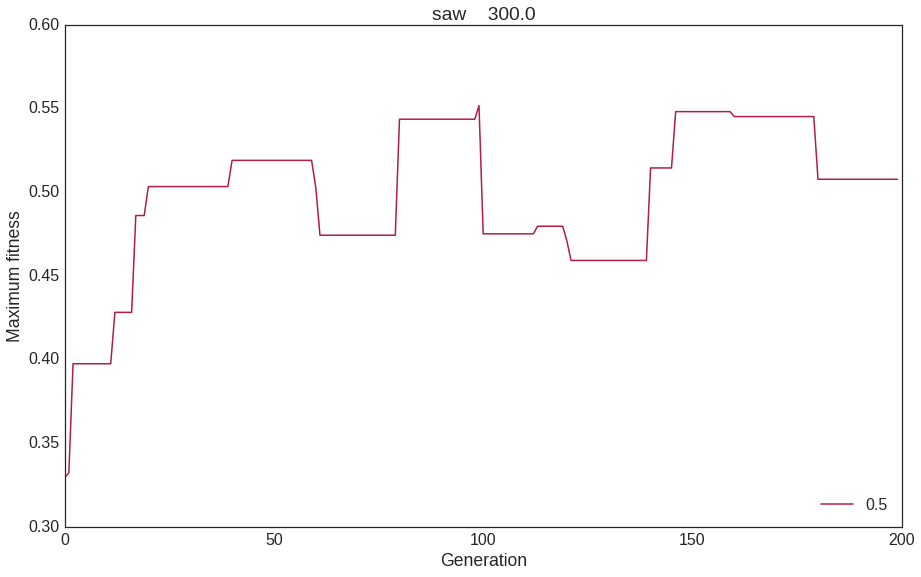

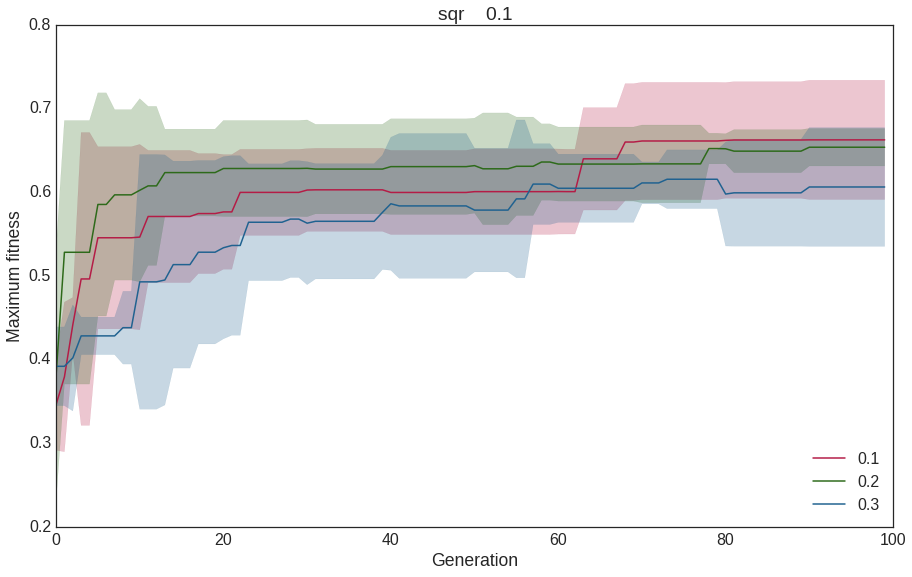

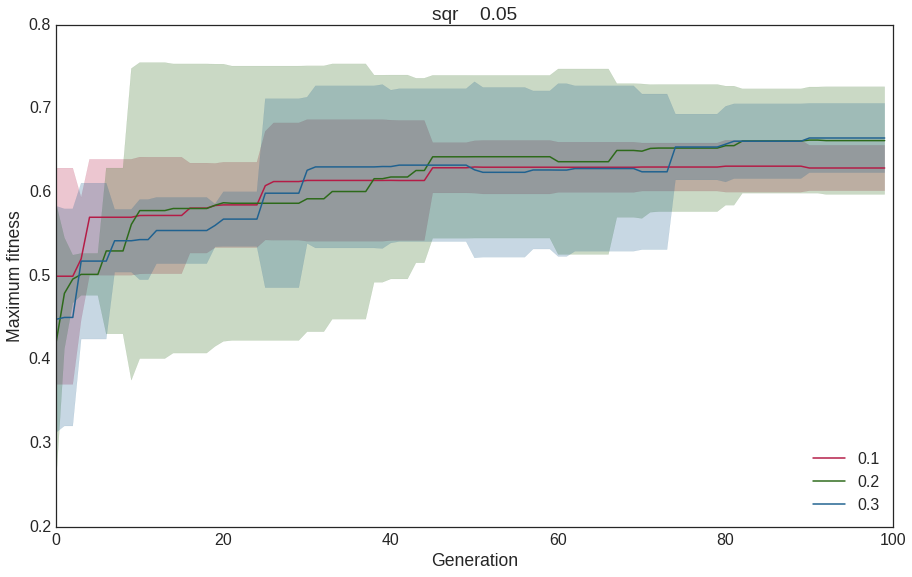

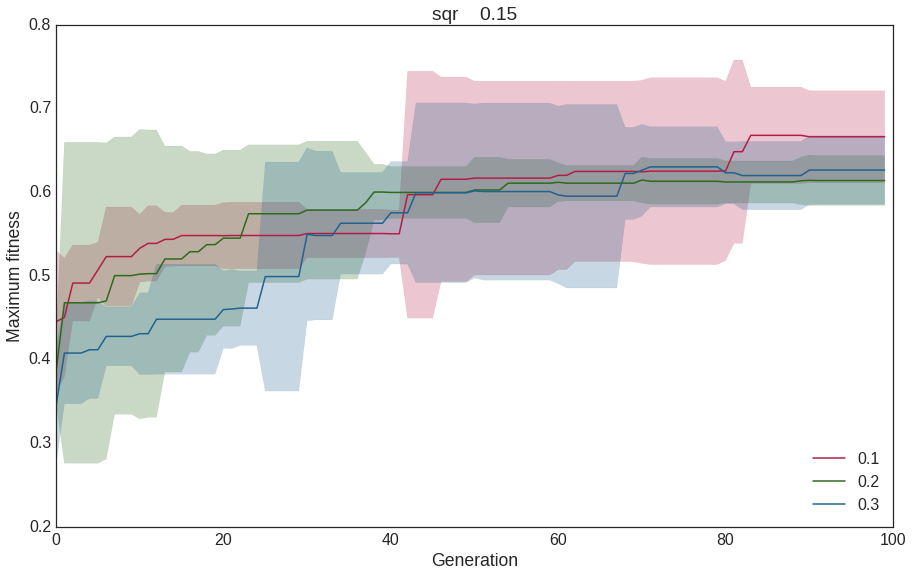

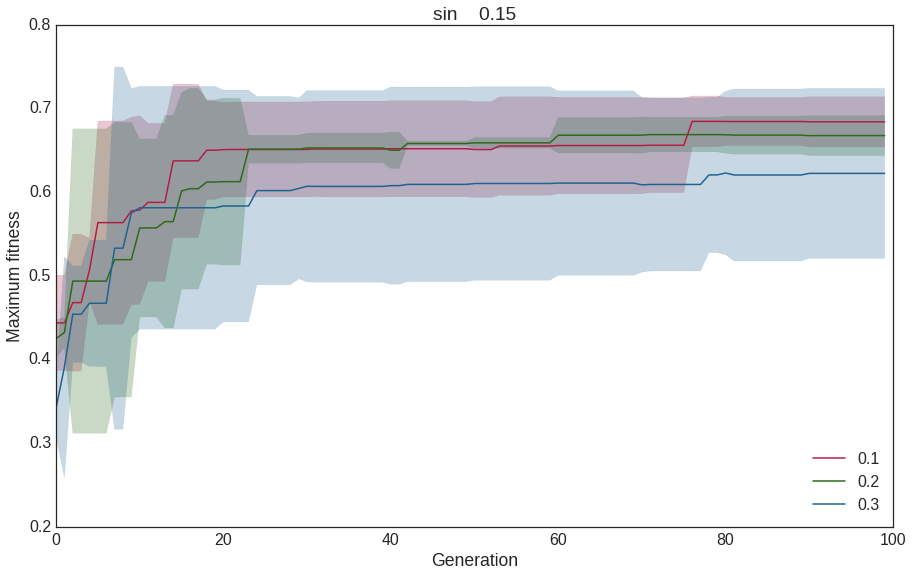

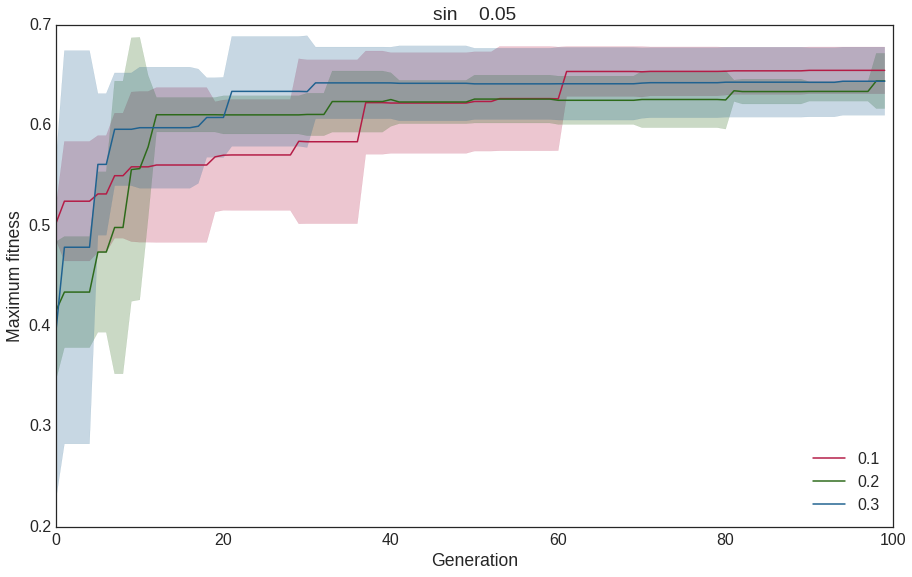

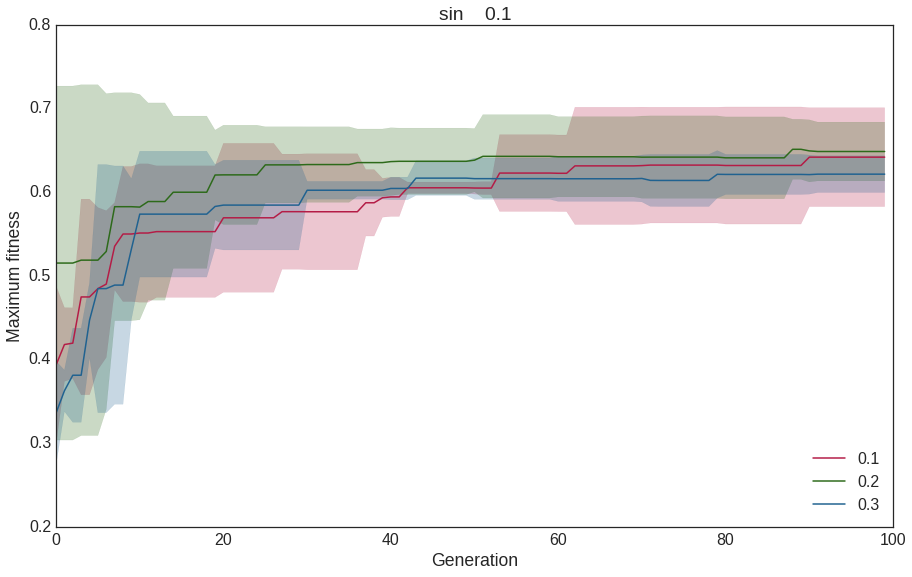

In [209]:
modelStats = getData('*/GA/modelStats*')
model_amp_aves,model_amp_std = calcAllStats(modelStats)
drawAllGAPlots_amps(model_amp_aves,model_amp_std)

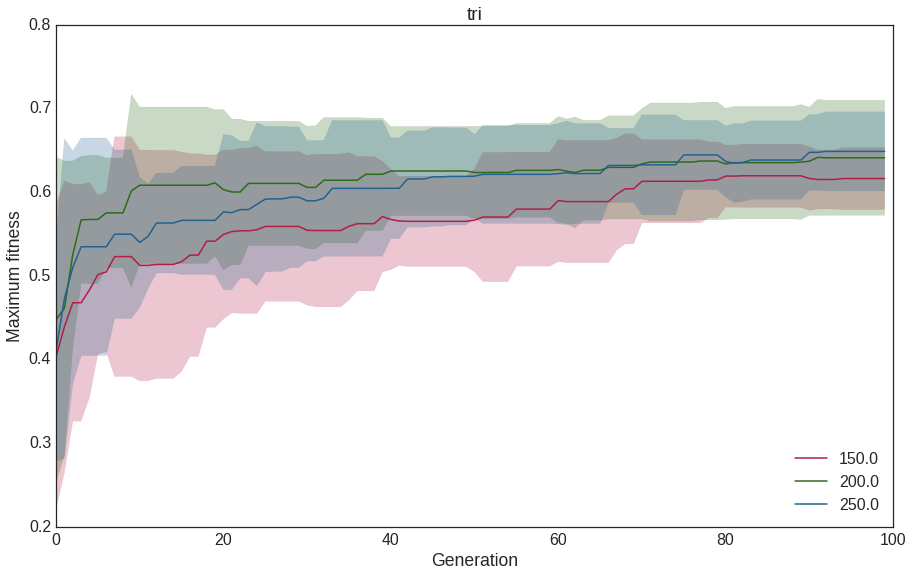

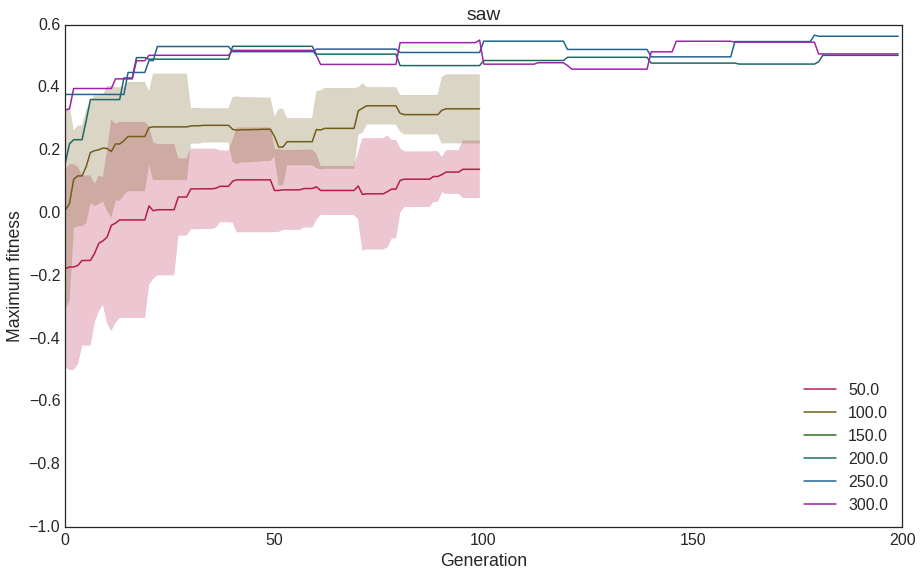

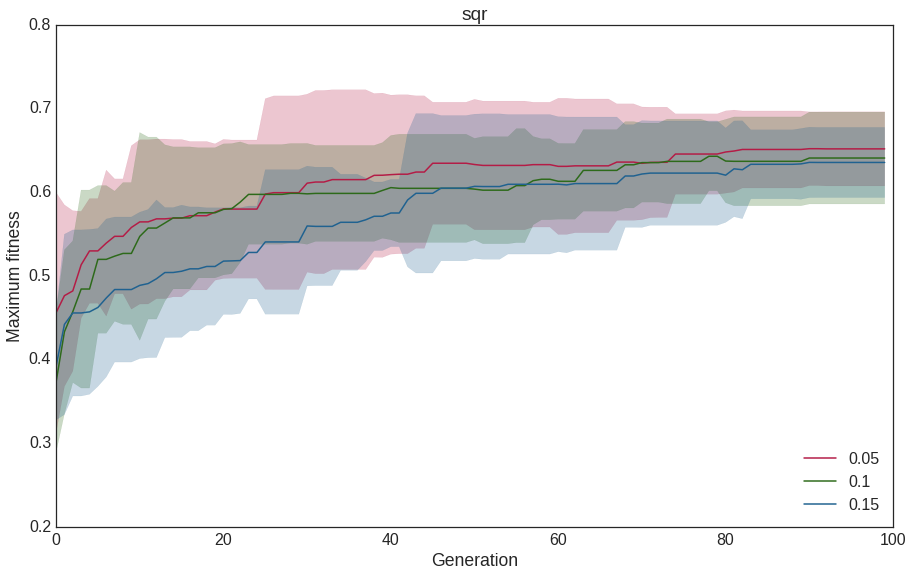

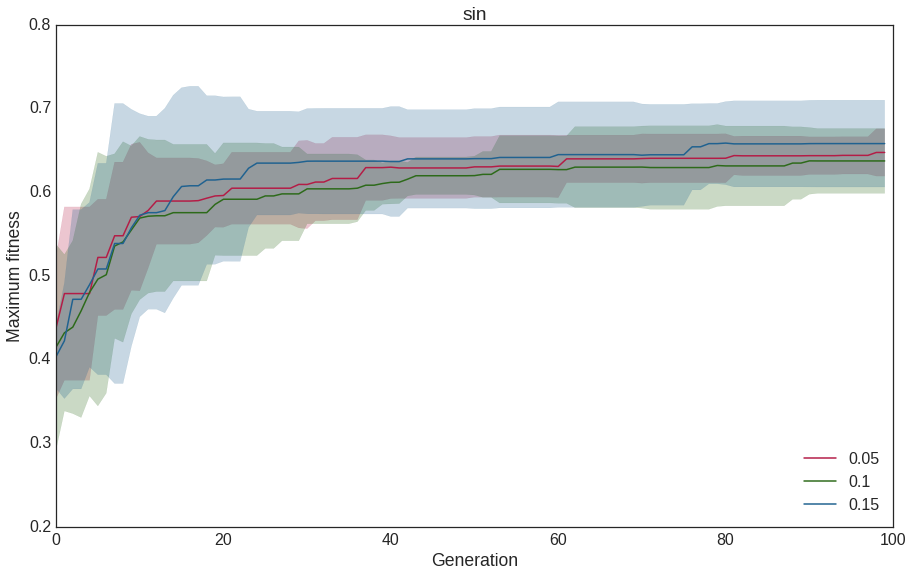

In [217]:
model_freq_aves,model_freq_stds = getFreqSummary(model_amp_aves,model_amp_std)
drawAllGAPlots_freqs(model_freq_aves,model_freq_stds)

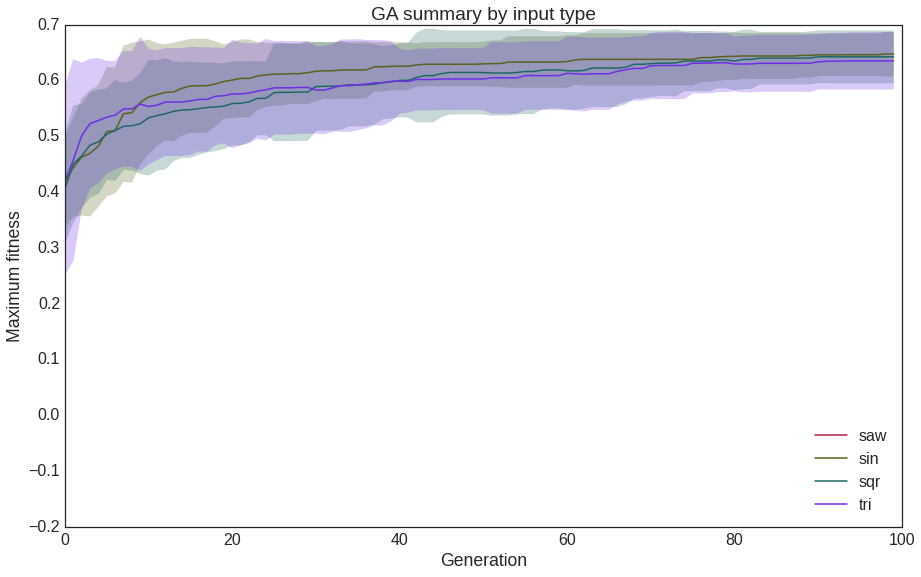

In [220]:
model_summary_aves,model_summary_stds = getTypSummary(model_freq_aves,model_freq_stds)
fig = drawGAPlots_typs(model_summary_aves,model_summary_stds)
fig.savefig('inputs_summary.pdf')
fig.show()

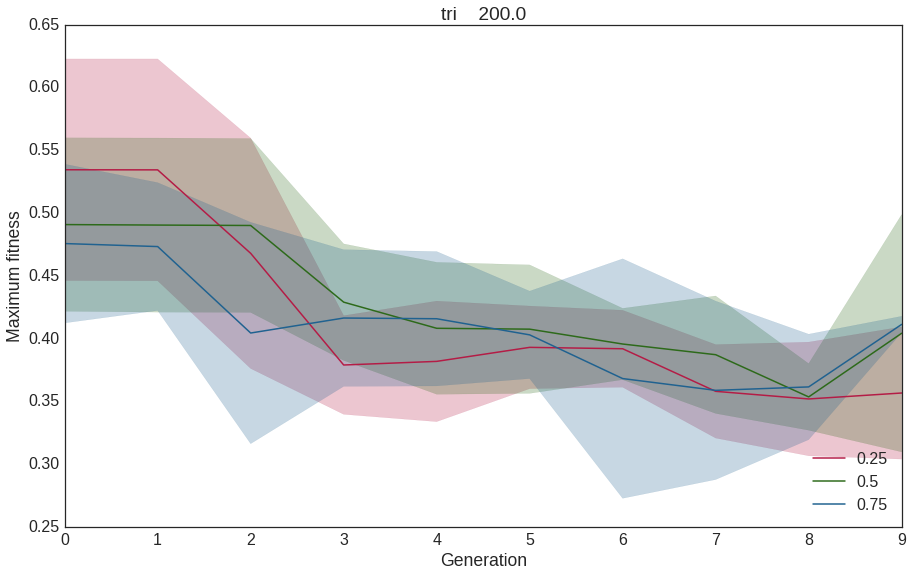

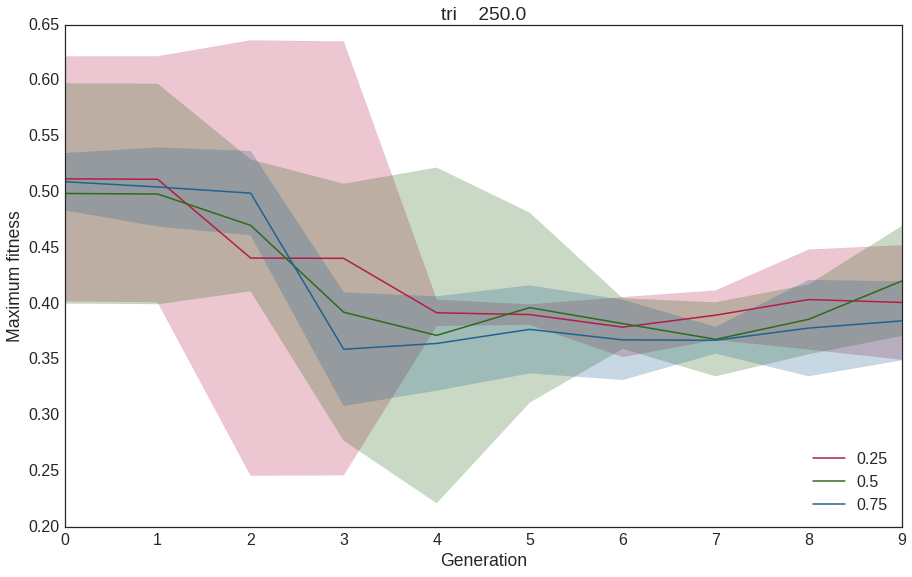

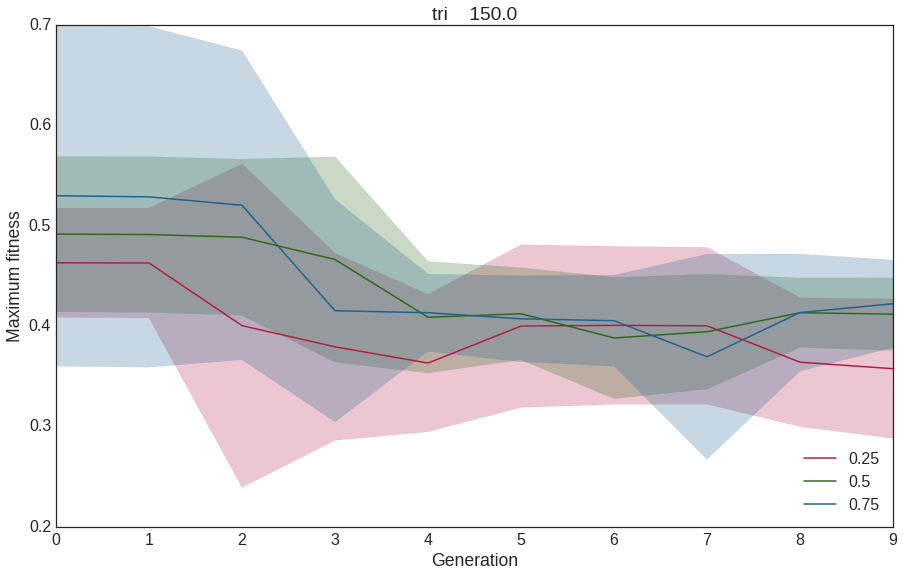

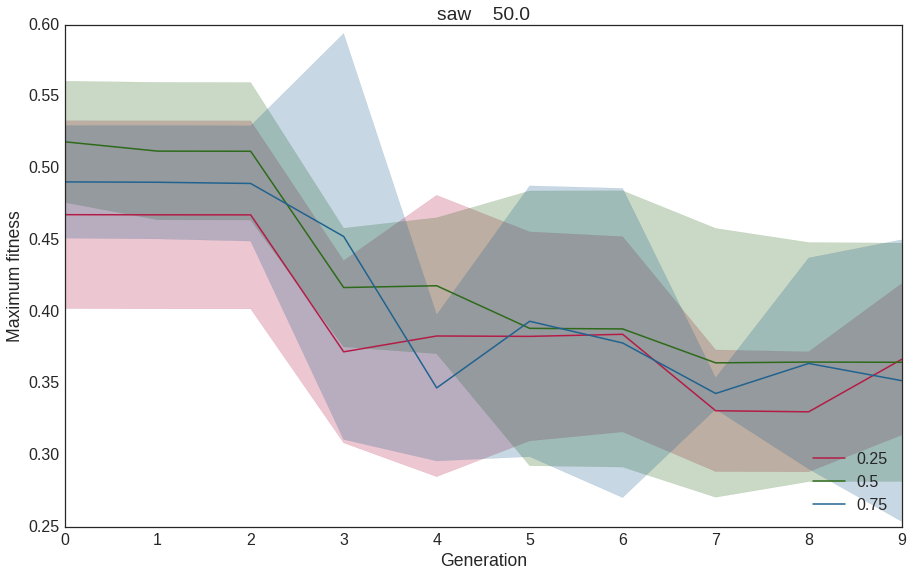

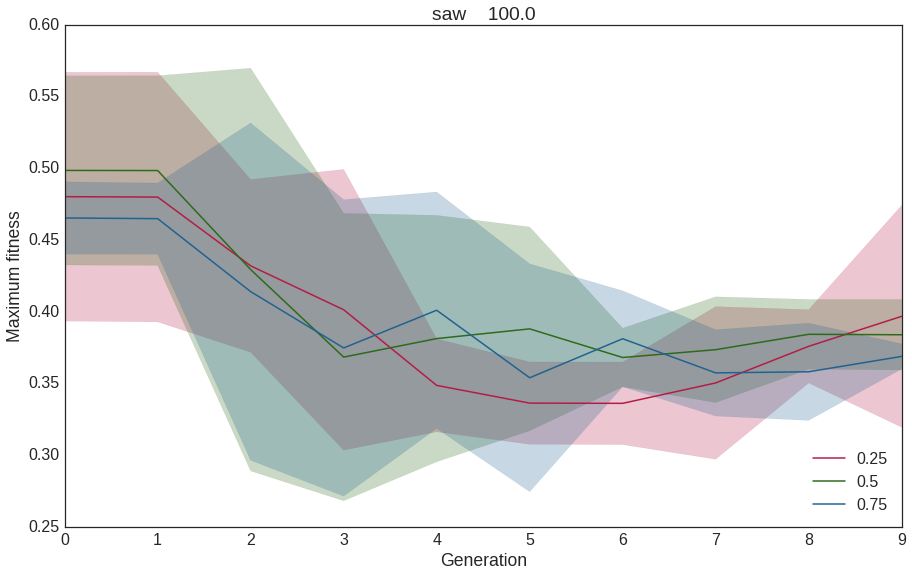

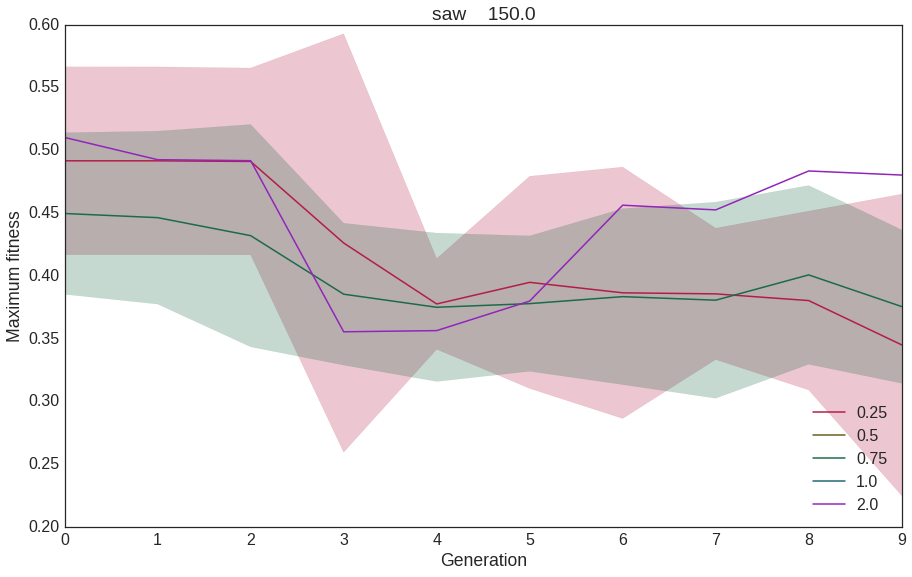

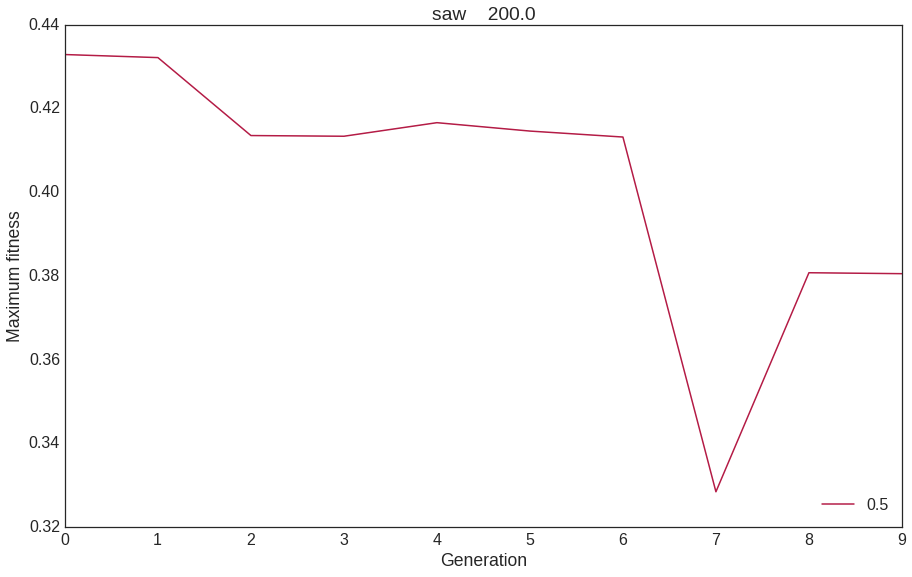

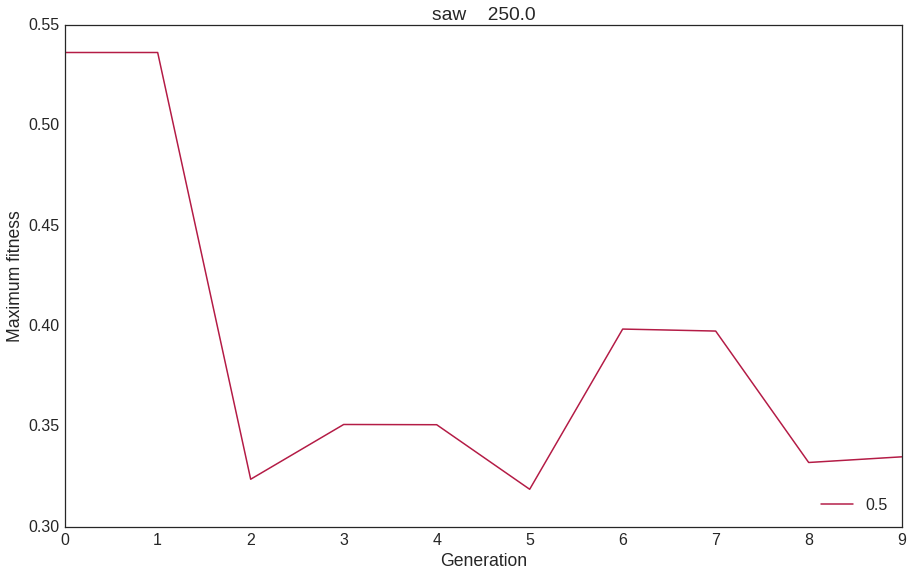

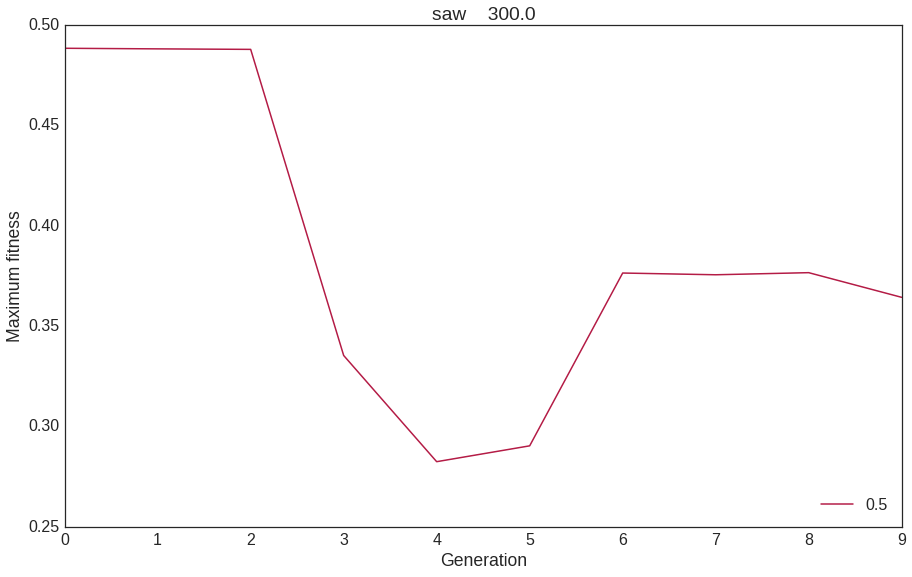

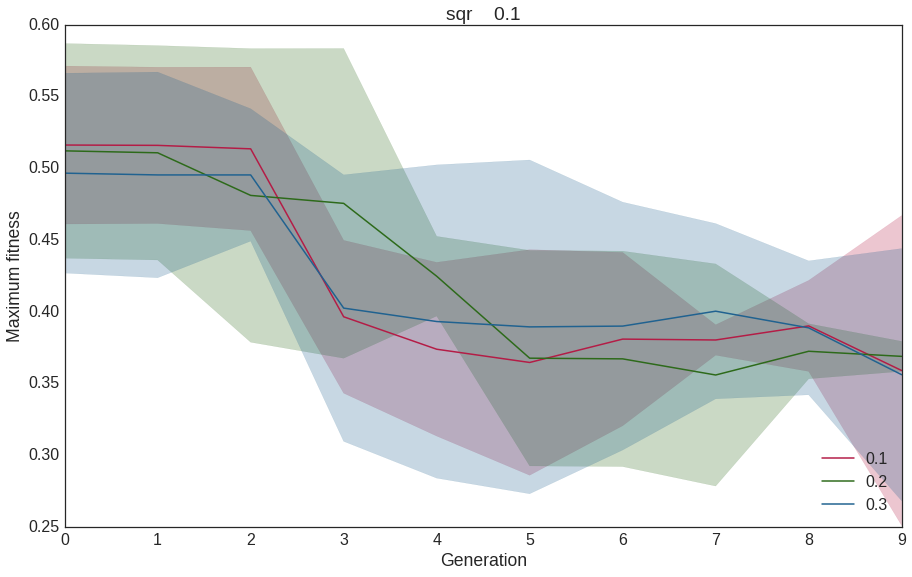

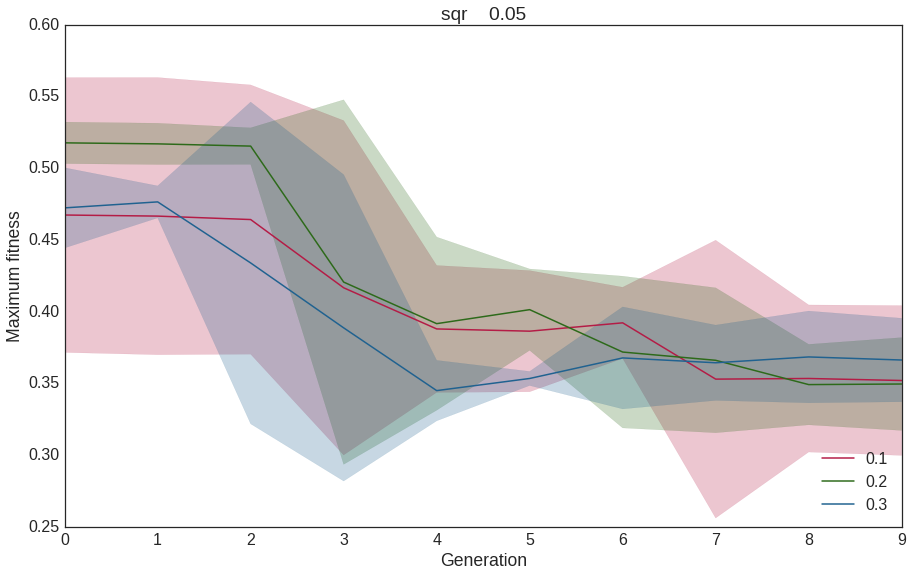

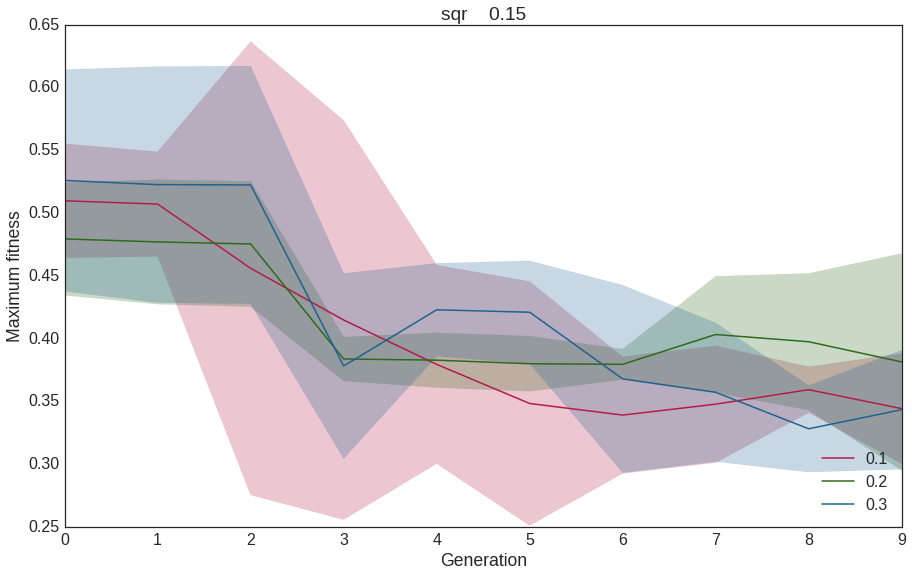

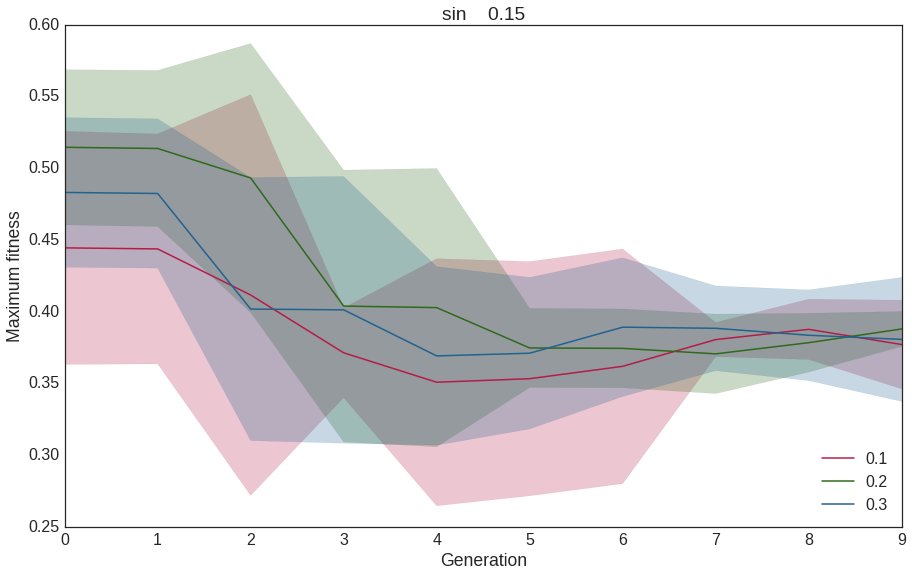

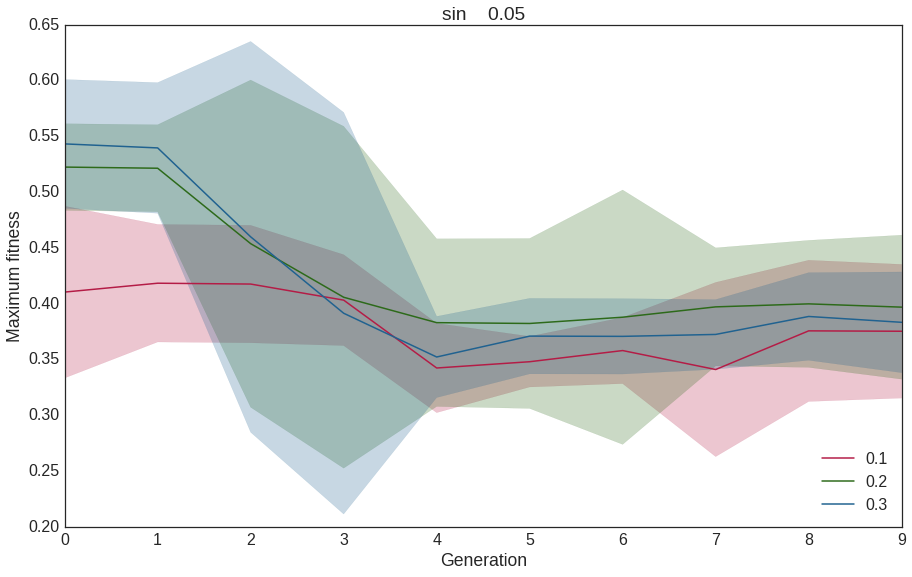

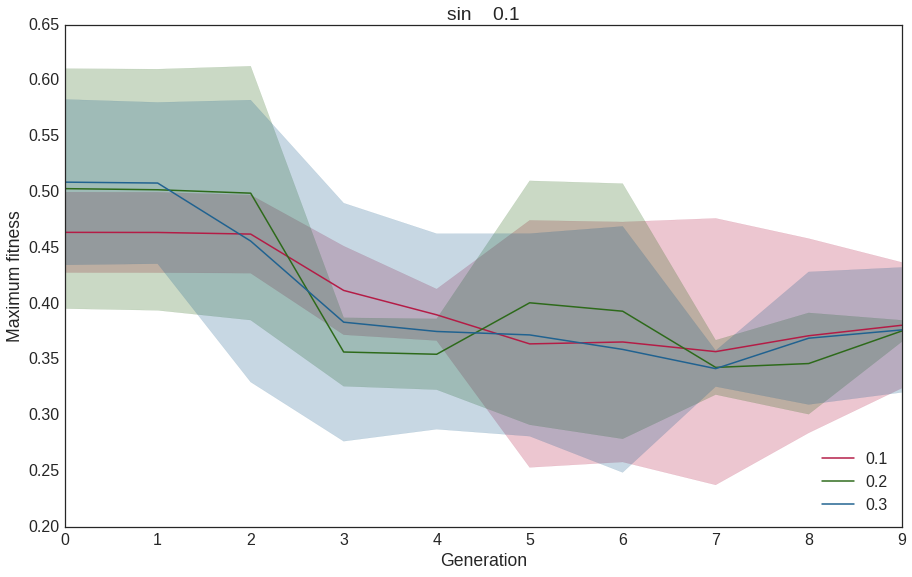

In [213]:
inputStats = getData('*/GA/inputStats*')
input_amp_aves,input_amp_std = calcAllStats(inputStats)
drawAllGAPlots_amps(input_amp_aves,input_amp_std)

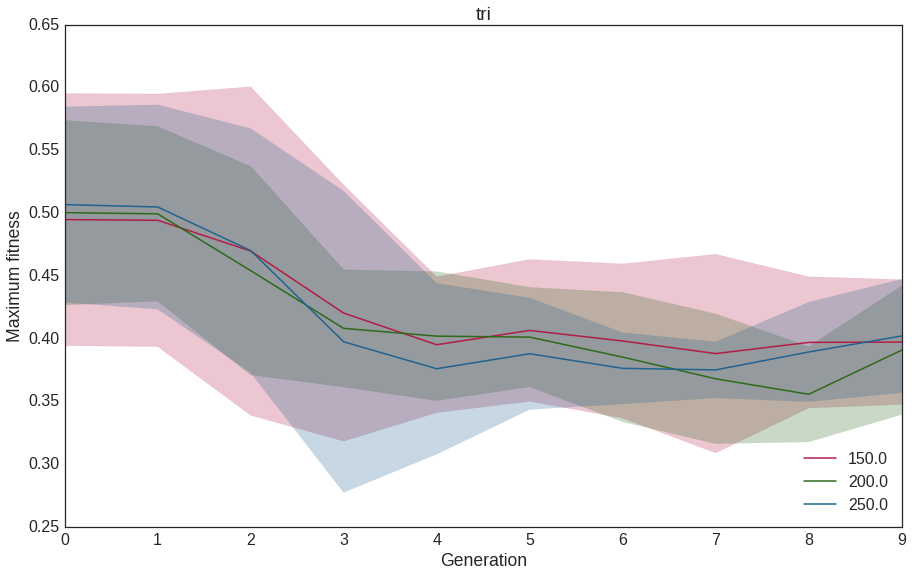

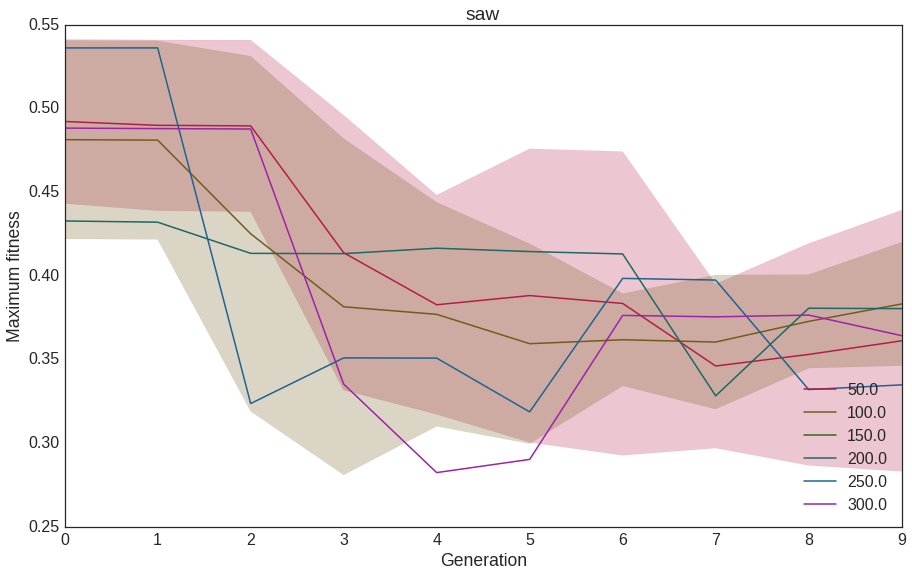

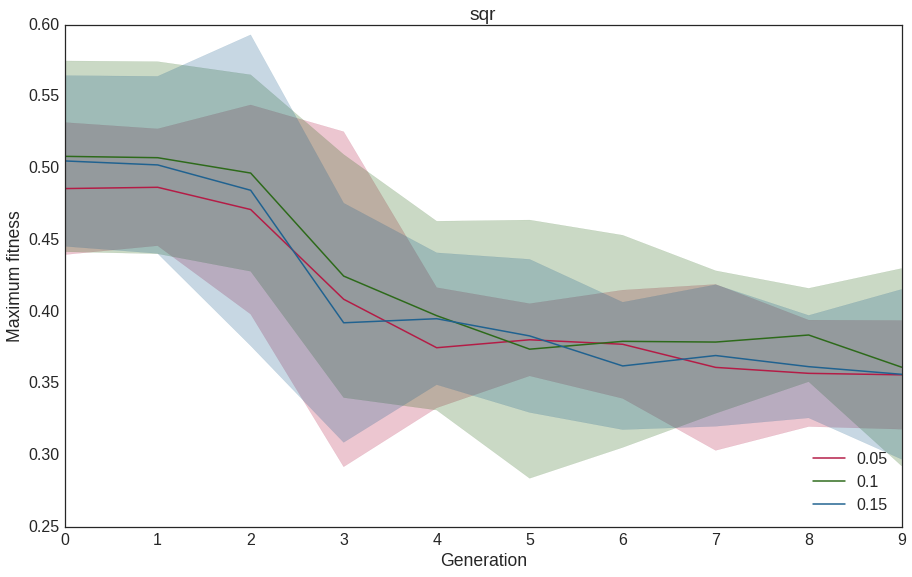

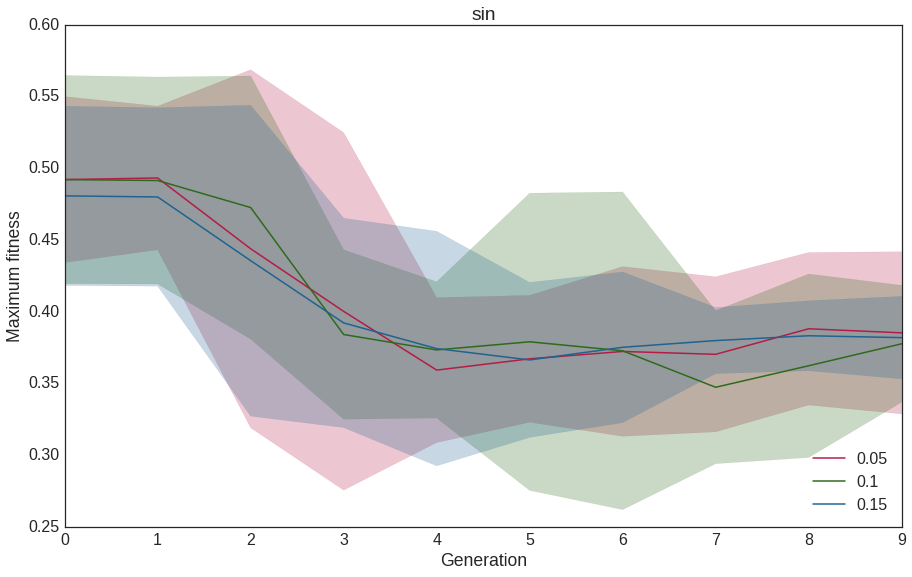

In [214]:
input_freq_aves,input_freq_stds = getFreqSummary(input_amp_aves,input_amp_std)
drawAllGAPlots_freqs(input_freq_aves,input_freq_stds)

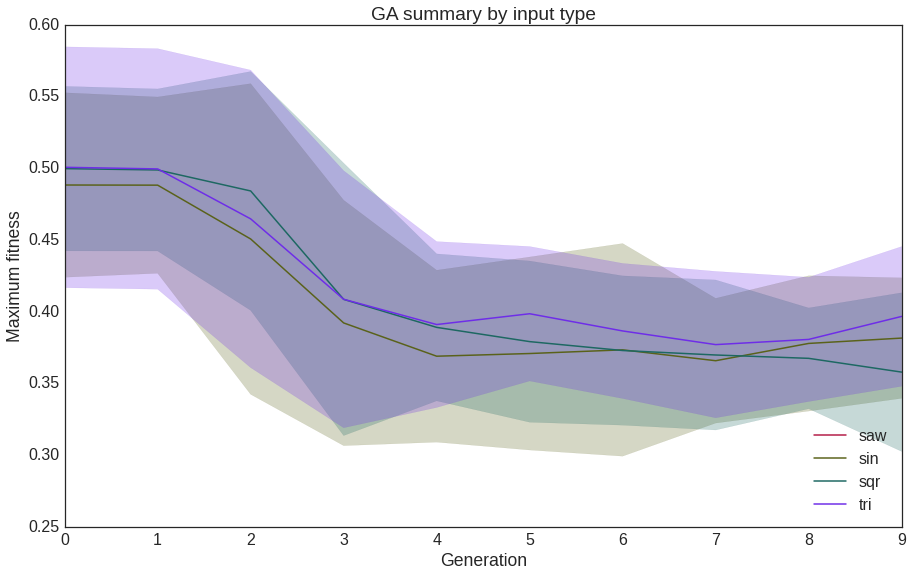

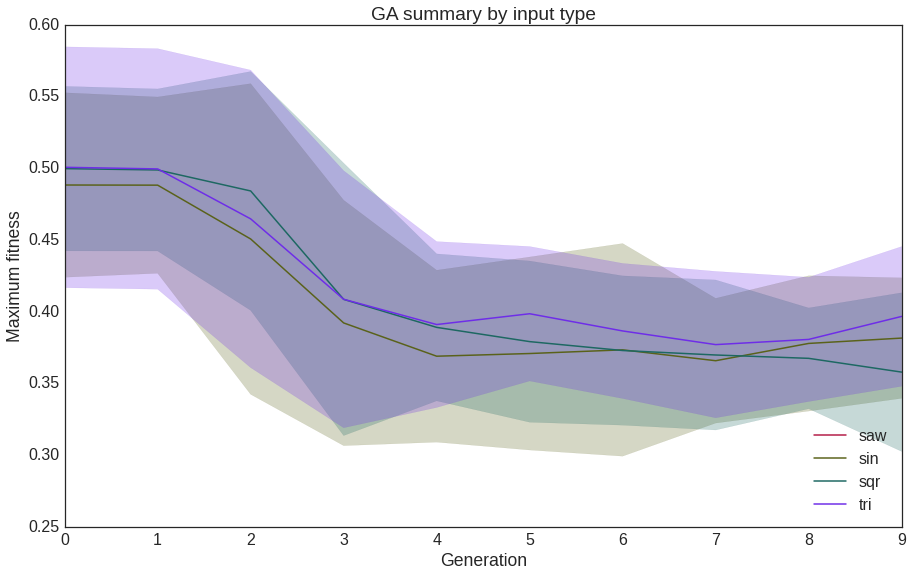

In [215]:
input_summary_aves,input_summary_stds = getTypSummary(input_freq_aves,input_freq_stds)
drawGAPlots_typs(input_summary_aves,input_summary_stds)

In [172]:
ctrnnExp = getData('*/inspector/evolvedLOG_exp*')
fixedExp = getData('*/inspector/fixedLOG_exp*')
ctrnnStd = getData('*/inspector/evolvedLOG_std*')
fixedStd = getData('*/inspector/fixedLOG_std*')

In [183]:
print(ctrnnExp['tri'].keys())
print(ctrnnExp['tri'][50.].keys())

dict_keys([50.0, 100.0, 150.0])
dict_keys([0.75, 0.25, 0.5])


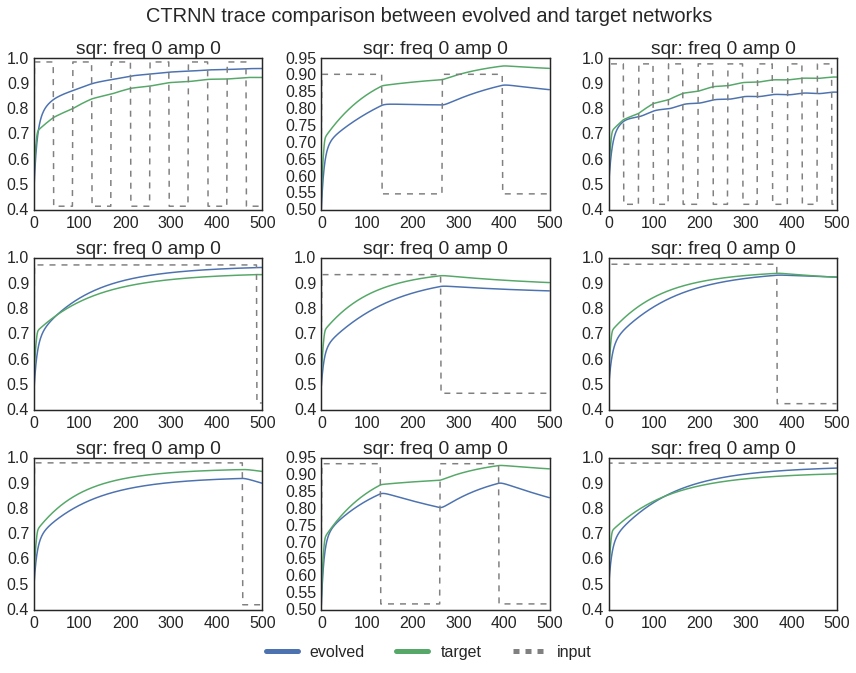

In [193]:
from matplotlib import patches,lines

fig,axes = plt.subplots(3,3,figsize=(9,5))
inputax = []

def plotCTRNN(ax,typ,freq,amp,index=0):
    ax.set_title("%s: freq %.f amp %.f" % (typ,freq,amp))
    line1=ax.plot(ctrnnExp[typ][freq][amp][index]['neur1'],label='model')
    line2=ax.plot(fixedExp[typ][freq][amp][index]['neur1'],label='target')
    inputax.append(ax.twinx())
    inputax[-1].plot(fixedExp[typ][freq][amp][index]['input0'],color='gray',linestyle='--')
    inputax[-1].set_yticklabels([])

index = 0
typ='sqr'
for i,freq in enumerate(ctrnnExp[typ].keys()):
    for j,amp in enumerate(ctrnnExp[typ][freq]):        
        plotCTRNN(axes[i,j],typ,freq,amp,index=index)
    
# plotCTRNN(axes[1],'saw',50,0.5,index=index)
# plotCTRNN(axes[2],'saw',50,0.75,index=index)
# plotCTRNN(axes[3],'saw',100,0.25,index=index)
# plotCTRNN(axes[4],'saw',100,0.5,index=index)
# plotCTRNN(axes[5],'saw',100,0.75,index=index)
# plotCTRNN(axes[6],'saw',150,0.25,index=index)
# plotCTRNN(axes[7],'saw',150,0.5,index=index)
# plotCTRNN(axes[8],'saw',150,0.75,index=index)

fig.set_size_inches(12,9)


model_patch = lines.Line2D([0],[0],color=seaborn.color_palette()[0],linewidth=5)
target_patch = lines.Line2D([0],[0],color=seaborn.color_palette()[1],linewidth=5)
input_line = lines.Line2D([0],[0],color='gray',linestyle='--',linewidth=5)

plt.figlegend([model_patch,target_patch,input_line],['evolved','target','input'],'lower center',ncol=3,bbox_to_anchor = (0,-0.05,1,1),
            bbox_transform = plt.gcf().transFigure)

fig.suptitle('CTRNN trace comparison between evolved and target networks',fontsize=20)
fig.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()